# IBM watsonx.governance Evaluation Studio - Tracking and Comparing AI Application Quality Evaluations

## Scenario Overview

Consider a development team building a RAG based chatbot—possibly using LLM Prompt or using an advanced agentic RAG chatbot—for their application. <br>
The underlying model powering the system is, say, the new introduced **OpenAI GPT5 model**.

During the development phase, the team evaluates the chatbot by asking a set of questions. For each question:
- The relevant **context** is retrieved,
- A **response** is generated by the chatbot, and
- A **ground truth answer** (as it can be available during development) is used for comparison.

In addition to this **test data set**, the team has prepared a **validation set** of questions, which are also run against the application.

To assess the quality of the responses, the team uses the **IBM watsonx.governance SDK** to compute:
- RAG-specific metrics such as **faithfulness**, **context relevance**, and **answer relevance**
- **Readability metrics** of the generated responses

Both the development and validation sets have corresponding computed metrics.

To **track these evaluations**, the team uses **Evaluation Studio** in **watsonx.governance**:
- An **AI Experiment** is created.
- Both evaluation runs (development and validation) are logged under this experiment.
- The experiment runs are then compared using **AI Evaluation**.
- Finally, the results and comparisons are **visualized through the Evaluation Studio UI** for further insights.

This notebook walks through this end-to-end workflow, and evaluates and compares the metrics that are produced from the output of GPT5 model.

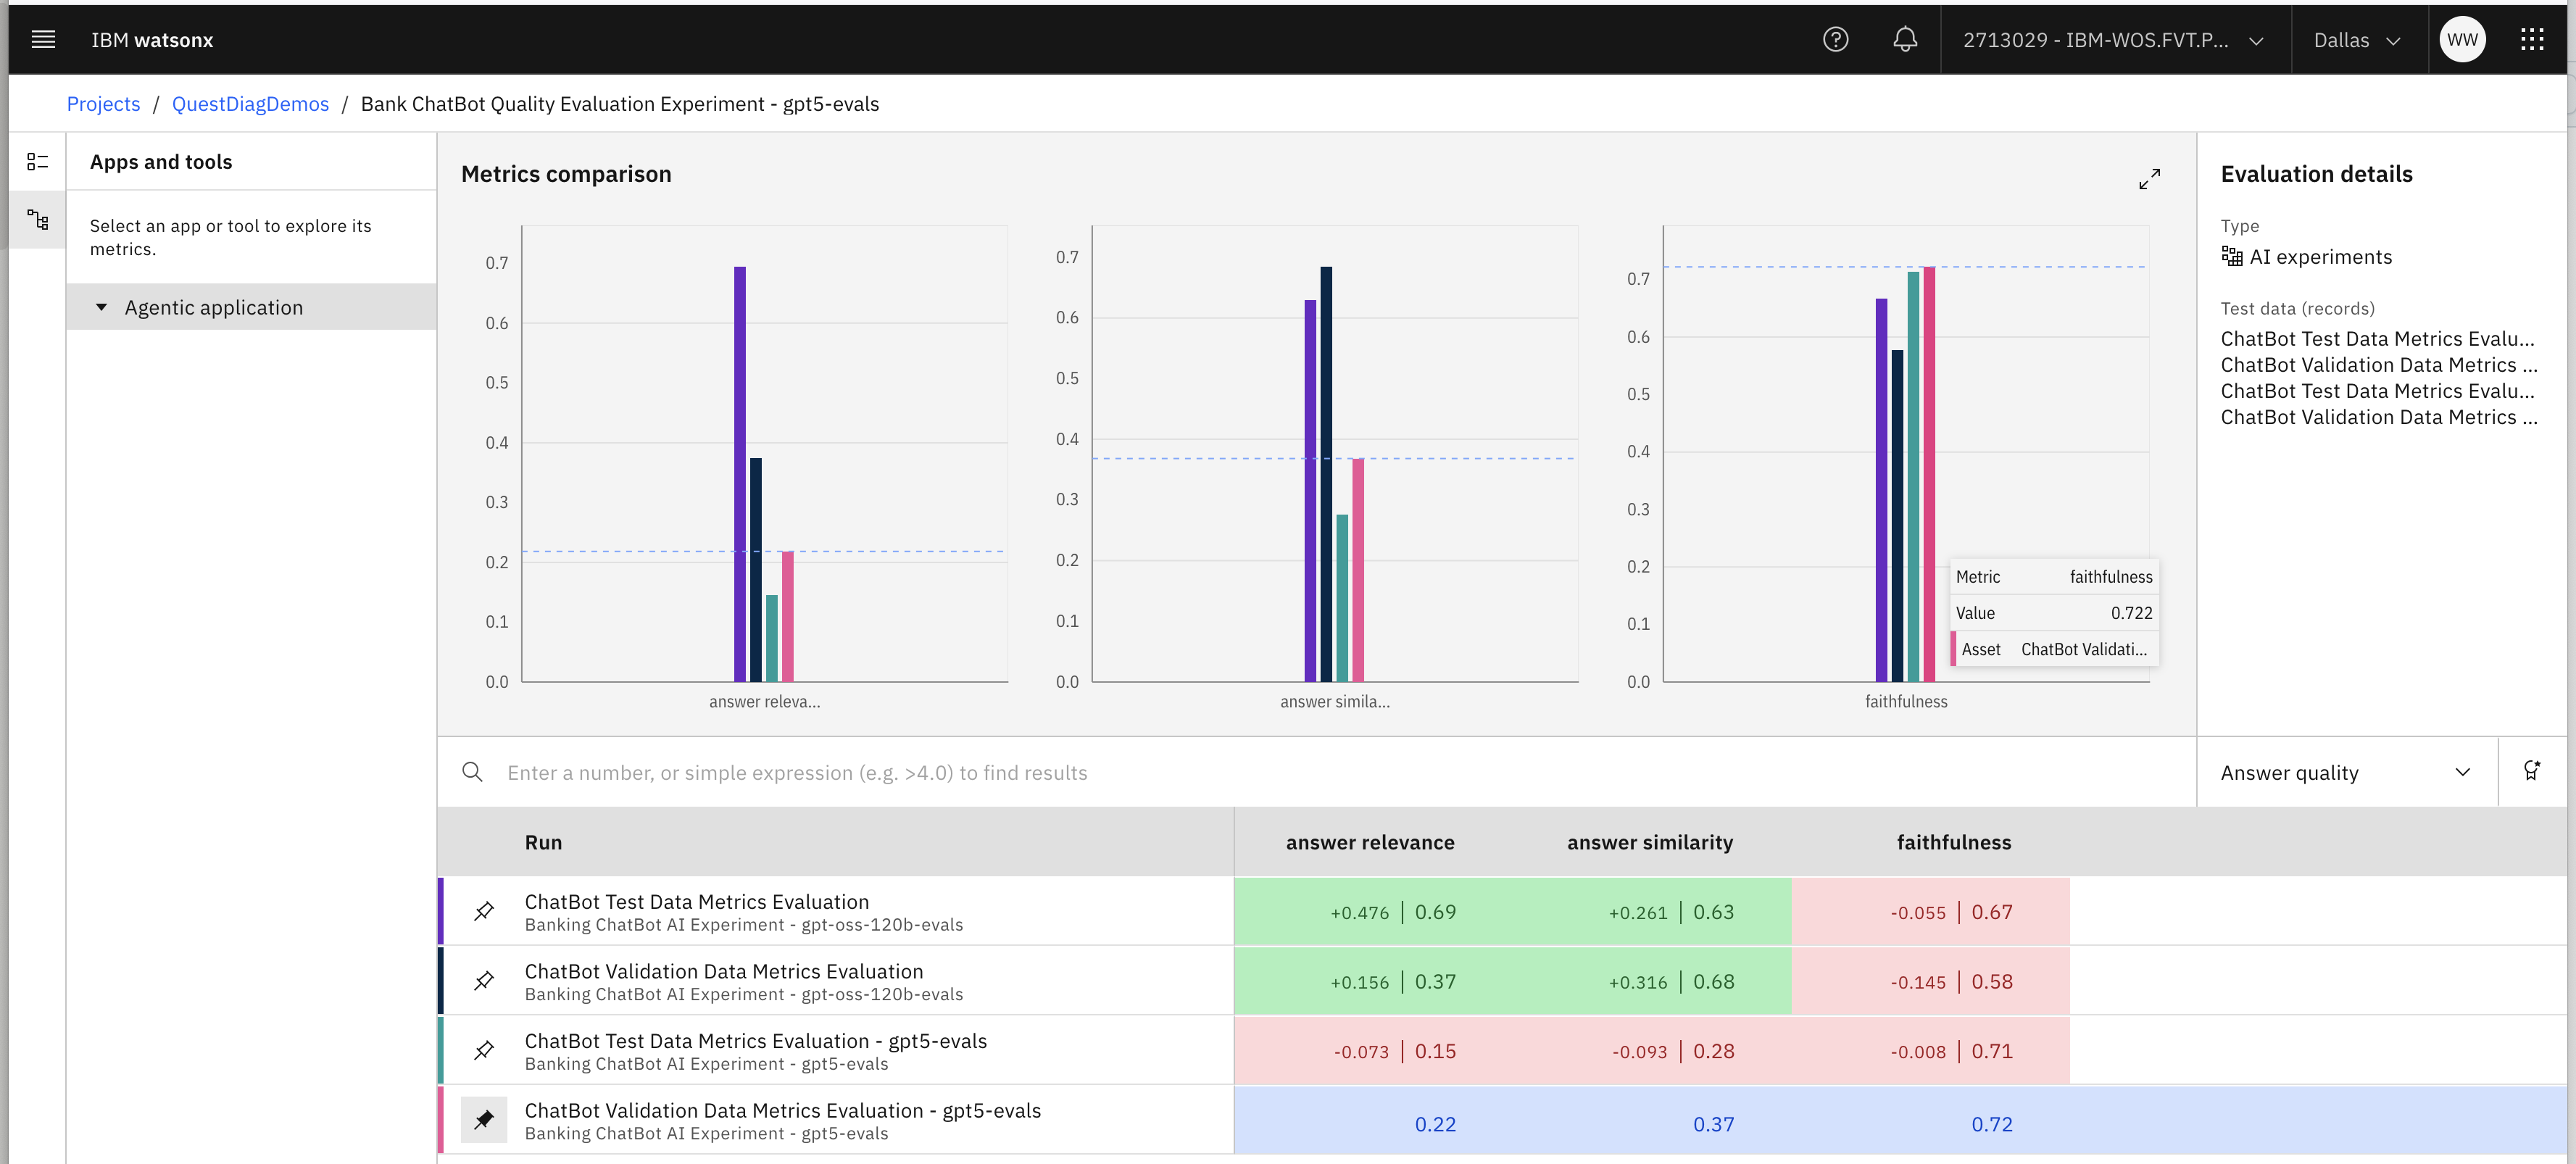

#### Required pip installations for IBM watsonx.governance SDK

In [ ]:
!pip install -U "ibm-watsonx-gov[metrics]" | tail -n 1
!pip install --upgrade openai | tail -n 1

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Credentials to run watsonx.gov SDK and AI Experiments

In [3]:
WX_AI_URL = 'https://us-south.ml.cloud.ibm.com'
IAM_API_KEY = "[Your IBM IAM API Key]"
project_id = "[Your IBM watsonx Project ID]"
WXG_INSTANCE_ID = '[Your IBM watsonx.governance instance ID]'
OPENAI_API_KEY = '[Your OpenAI API Key]'

In [4]:
from openai import OpenAI
openai_client = OpenAI(api_key=OPENAI_API_KEY)

# Utility method to call the OpenAI GPT5 model

In [5]:
# Function to query GPT-5
def generate_gpt5_answer(question, context):
    content = "You are a helpful assistant. Use the provided context to answer the question. \
        If you do not know the answer, just say 'I do not know' rather than providing made up answers. \
        Answer the question in a human readable format without any HTML and Markup and Markdown conent. \
        Make sure the output is with a maximum of 20 tokens. "

    prompt = f"""
    You are a knowledgeable assistant. 
    Context: {context}
    Question: {question}
    Provide a concise and accurate answer based only on the given context.
    """
    
    response = openai_client.chat.completions.create(
        model="gpt-5",
        messages=[
            {"role": "system", "content": content},
            {"role": "user", "content": prompt}
        ]
    )
    
    return response.choices[0].message.content.strip()

## Test data 

In [6]:
!rm -fr banking_rag_chatbot_qna_1.csv
!wget "https://raw.githubusercontent.com/ravichamarthy/watsonx-explorations/refs/heads/main/banking_rag_chatbot_qna_1.csv"

--2025-08-09 18:27:42--  https://raw.githubusercontent.com/ravichamarthy/watsonx-explorations/refs/heads/main/banking_rag_chatbot_qna_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3995 (3.9K) [text/plain]
Saving to: ‘banking_rag_chatbot_qna_1.csv’

banking_rag_chatbot 100%[===================>]   3.90K  --.-KB/s    in 0s      

2025-08-09 18:27:42 (24.4 MB/s) - ‘banking_rag_chatbot_qna_1.csv’ saved [3995/3995]



In [7]:
import pandas as pd
banking_rag_chatbot_qna_1 = pd.read_csv("banking_rag_chatbot_qna_1.csv")
banking_rag_chatbot_qna_1.head()

,question,context,answer,grouth_truth
0,What is the minimum balance required for a sav...,The minimum average monthly balance (AMB) requ...,The minimum balance required is 10000 for urba...,"Depending on the branch location, the required..."
1,Can I open a fixed deposit online?,"Yes, customers with access to internet banking...","Yes, you can open a fixed deposit online via i...","Yes, fixed deposits can be opened online via i..."
2,How can I block my lost debit card?,"If your debit card is lost or stolen, it is cr...",You should block your lost debit card immediat...,Immediately block your lost debit card using m...
3,What is the interest rate on personal loans?,The bank offers personal loans at interest rat...,Personal loan interest rates range between 10....,Interest rates for personal loans range from 1...
4,Are NRIs eligible for home loans?,Non-Resident Indians (NRIs) are eligible to ap...,"Yes, NRIs can get home loans in India for up t...",NRIs can apply for home loans up to 20 years t...


## Test Data - Using the context and the question, invoke the GPT OSS 120b model to get the response

In [8]:
banking_rag_chatbot_qna_1["gpt5_generated_answer"] = banking_rag_chatbot_qna_1.apply(
    lambda row: generate_gpt5_answer(row["context"], row["question"]),
    axis=1
)

In [9]:
banking_rag_chatbot_qna_1

,question,context,answer,grouth_truth,gpt5_generated_answer
0,What is the minimum balance required for a sav...,The minimum average monthly balance (AMB) requ...,The minimum balance required is 10000 for urba...,"Depending on the branch location, the required...","AMB: Urban 10,000; Semi-urban 5,000; Rural 2,0..."
1,Can I open a fixed deposit online?,"Yes, customers with access to internet banking...","Yes, you can open a fixed deposit online via i...","Yes, fixed deposits can be opened online via i...",Yes—via internet/mobile banking; 7 days–10 yea...
2,How can I block my lost debit card?,"If your debit card is lost or stolen, it is cr...",You should block your lost debit card immediat...,Immediately block your lost debit card using m...,"Block via mobile app, internet banking, or 180..."
3,What is the interest rate on personal loans?,The bank offers personal loans at interest rat...,Personal loan interest rates range between 10....,Interest rates for personal loans range from 1...,10.99% to 16.99% p.a.; depends on profile. Ten...
4,Are NRIs eligible for home loans?,Non-Resident Indians (NRIs) are eligible to ap...,"Yes, NRIs can get home loans in India for up t...",NRIs can apply for home loans up to 20 years t...,Yes. NRIs eligible: up to 20-year tenure; repa...


## Validation data 

In [10]:
!rm -fr banking_rag_chatbot_qna_2.csv
!wget "https://raw.githubusercontent.com/ravichamarthy/watsonx-explorations/refs/heads/main/banking_rag_chatbot_qna_2.csv"

--2025-08-09 18:28:42--  https://raw.githubusercontent.com/ravichamarthy/watsonx-explorations/refs/heads/main/banking_rag_chatbot_qna_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3308 (3.2K) [text/plain]
Saving to: ‘banking_rag_chatbot_qna_2.csv’

banking_rag_chatbot 100%[===================>]   3.23K  --.-KB/s    in 0s      

2025-08-09 18:28:42 (18.6 MB/s) - ‘banking_rag_chatbot_qna_2.csv’ saved [3308/3308]



In [11]:
banking_rag_chatbot_qna_2 = pd.read_csv("banking_rag_chatbot_qna_2.csv")
banking_rag_chatbot_qna_2.head()

,question,context,answer,grouth_truth
0,How can I apply for a credit card online?,"To apply for a credit card online, customers c...",You can apply for a credit card online by subm...,"Visit the bank’s website or app, choose a card..."
1,What are the features of mobile banking?,The mobile banking app offers a wide range of ...,"Mobile banking offers fund transfers, bill pay...","Mobile banking supports transfers, bill paymen..."
2,How do I close my bank account?,"To close your bank account, visit the nearest ...","To close your account, visit the branch with a...",You must visit the branch with ID proof and su...
3,Can I link multiple bank accounts to one UPI ID?,"Yes, UPI apps allow users to link multiple ban...","Yes, you can link multiple accounts to one UPI...","Yes, UPI apps support linking multiple account..."
4,What happens if I miss an EMI payment?,Missing an EMI (Equated Monthly Installment) p...,"If you miss an EMI, it can affect your credit ...","Missing an EMI leads to penalties, interest, a..."


## Validation Data - Using the context and the question, invoke the GPT OSS 120b model to get the response

In [12]:
banking_rag_chatbot_qna_2["gpt5_generated_answer"] = banking_rag_chatbot_qna_2.apply(
    lambda row: generate_gpt5_answer(row["context"], row["question"]),
    axis=1
)

In [13]:
banking_rag_chatbot_qna_2

,question,context,answer,grouth_truth,gpt5_generated_answer
0,How can I apply for a credit card online?,"To apply for a credit card online, customers c...",You can apply for a credit card online by subm...,"Visit the bank’s website or app, choose a card...","Apply via bank site/app; submit personal, inco..."
1,What are the features of mobile banking?,The mobile banking app offers a wide range of ...,"Mobile banking offers fund transfers, bill pay...","Mobile banking supports transfers, bill paymen...","Features: balance inquiry, NEFT/IMPS/RTGS, bil..."
2,How do I close my bank account?,"To close your bank account, visit the nearest ...","To close your account, visit the branch with a...",You must visit the branch with ID proof and su...,"Visit a branch with ID, unused chequebook and ..."
3,Can I link multiple bank accounts to one UPI ID?,"Yes, UPI apps allow users to link multiple ban...","Yes, you can link multiple accounts to one UPI...","Yes, UPI apps support linking multiple account...",Yes. You can link multiple accounts to one UPI...
4,What happens if I miss an EMI payment?,Missing an EMI (Equated Monthly Installment) p...,"If you miss an EMI, it can affect your credit ...","Missing an EMI leads to penalties, interest, a...","Expect late fees, extra interest, credit score..."


# IBM watsonx.gov SDK evaluations starts

### Configurations

- Define the `GenAIConfiguration`, specifying which fields represent the **question**, **context**, the **response**, and the **grount truth**
- Configure the use of **RAG evaluation metrics**, which require the **input question**, **retrieved context**, **generated response**, and the **ground truth answer**.
- *(Note: Only a subset of available metrics is shown here. For the complete list, refer to the [watsonx.governance documentation](https://ibm.github.io/ibm-watsonx-gov/index.html).)*
- Also, please note only the string based lexical evaluations are made for the metrics, so the metrics results may or may not be that great. To get good results, one should use watsonx.gov Smaller Models or the Granite Guardian way of computing the RAG metrics.

In [14]:
from ibm_watsonx_gov.config import GenAIConfiguration
from ibm_watsonx_gov.metrics import AnswerRelevanceMetric
from ibm_watsonx_gov.metrics import AnswerSimilarityMetric
from ibm_watsonx_gov.metrics import FaithfulnessMetric
from ibm_watsonx_gov.metrics import ContextRelevanceMetric
from ibm_watsonx_gov.metrics import TextGradeLevelMetric
from ibm_watsonx_gov.metrics import TextReadingEaseMetric
from ibm_watsonx_gov.entities.enums import TaskType, MetricGroup
from ibm_watsonx_gov.clients.api_client import APIClient
from ibm_watsonx_gov.entities.credentials import Credentials

config = GenAIConfiguration(
    input_fields=["question"],
    context_fields=["context"],
    output_fields=["gpt5_generated_answer"],
    reference_fields=["grouth_truth"]
)

metrics = [
    AnswerRelevanceMetric(),
    AnswerSimilarityMetric(),
    FaithfulnessMetric(),
    ContextRelevanceMetric(),
    TextGradeLevelMetric(),
    TextReadingEaseMetric(),
]
api_client = APIClient(
    credentials=Credentials(
        api_key=IAM_API_KEY,
        service_instance_id=WXG_INSTANCE_ID
    )
)

### Evaluate the Metrics
- Create MetricsEvaluator
- Evaluate the metrics against the data produced from the underlying prompt or Agent

In [15]:
from ibm_watsonx_gov.evaluators import MetricsEvaluator

evaluator = MetricsEvaluator(
    api_client = api_client,
    configuration=config,
)

## Evaluate on Test Data

In [16]:
evaluation_results_1 = evaluator.evaluate(
    data=banking_rag_chatbot_qna_1,
    metrics=metrics
)
evaluation_results_df_1 = evaluation_results_1.to_df()
evaluation_results_df_1

,answer_relevance.token_recall,answer_similarity.token_recall,faithfulness.token_k_precision,context_relevance.token_precision,text_grade_level.flesch_kincaid_grade,text_reading_ease.flesch_reading_ease
0,0.000000,0.318182,0.666667,0.625000,6.416667,59.745000
1,0.000000,0.200000,0.625000,0.833333,16.462500,5.532500
2,0.250000,0.263158,0.833333,0.625000,5.890000,64.708333
3,0.142857,0.240000,0.812500,0.714286,1.457500,91.737500
4,0.333333,0.357143,0.631579,1.000000,14.798947,22.802632


## Evaluate on Validation Data

In [17]:
evaluation_results_2 = evaluator.evaluate(
    data=banking_rag_chatbot_qna_2,
    metrics=metrics
)
evaluation_results_df_2 = evaluation_results_2.to_df()
evaluation_results_df_2

,answer_relevance.token_recall,answer_similarity.token_recall,faithfulness.token_k_precision,context_relevance.token_precision,text_grade_level.flesch_kincaid_grade,text_reading_ease.flesch_reading_ease
0,0.125000,0.346154,0.684211,0.750000,11.072632,49.518421
1,0.166667,0.208333,0.812500,0.666667,12.037500,37.257500
2,0.000000,0.478261,0.823529,0.428571,14.374444,24.065000
3,0.800000,0.545455,0.789474,0.800000,8.730000,68.095000
4,0.000000,0.263158,0.500000,0.285714,14.987500,16.107500


## Utility method to average the individual record level metrics, and construct the Experiment Run object

In [18]:
def construct_run_metrics(df):
    import pandas as pd
    
    # Define column mapping and grouping
    metric_mapping = {
        'answer_relevance.token_recall': ('answer_relevance', 'answer_quality'),
        'answer_similarity.token_recall': ('answer_similarity', 'answer_quality'),
        'faithfulness.token_k_precision': ('faithfulness', 'answer_quality'),
        'context_relevance.token_precision': ('context_relevance', 'retrieval_quality'),
        'text_grade_level.flesch_kincaid_grade': ('text_grade_level', 'readability'),
        'text_reading_ease.flesch_reading_ease': ('text_reading_ease', 'readability')
    }
    
    # Aggregate and build JSON list
    run_metric_results = []
    for col, (new_name, group) in metric_mapping.items():
        if col in df.columns:
            avg_value = df[col].mean()
            count = df[col].count()
            run_metric_results.append({
                "name": new_name,
                "value": round(avg_value, 4),
                "group": group,
                "count": int(count)
            })

    return run_metric_results

## Test Data Run metrics

In [19]:
run_1_metric_results = construct_run_metrics(evaluation_results_df_1)
# Preview result
import json
print(json.dumps(run_1_metric_results, indent=2))

[
  {
    "name": "answer_relevance",
    "value": 0.1452,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "answer_similarity",
    "value": 0.2757,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "faithfulness",
    "value": 0.7138,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "context_relevance",
    "value": 0.7595,
    "group": "retrieval_quality",
    "count": 5
  },
  {
    "name": "text_grade_level",
    "value": 9.0051,
    "group": "readability",
    "count": 5
  },
  {
    "name": "text_reading_ease",
    "value": 48.9052,
    "group": "readability",
    "count": 5
  }
]


## Validation Data Run Metrics

In [20]:
run_2_metric_results = construct_run_metrics(evaluation_results_df_2)
# Preview result
import json
print(json.dumps(run_2_metric_results, indent=2))

[
  {
    "name": "answer_relevance",
    "value": 0.2183,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "answer_similarity",
    "value": 0.3683,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "faithfulness",
    "value": 0.7219,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "context_relevance",
    "value": 0.5862,
    "group": "retrieval_quality",
    "count": 5
  },
  {
    "name": "text_grade_level",
    "value": 12.2404,
    "group": "readability",
    "count": 5
  },
  {
    "name": "text_reading_ease",
    "value": 39.0087,
    "group": "readability",
    "count": 5
  }
]


# Creating AI Experiment asset to capture Metrics Evaluation Runs

In [21]:
from ibm_watsonx_gov.ai_experiments.ai_experiments_client import AIExperimentsClient
from ibm_watsonx_gov.entities.ai_experiment import AIExperimentRun, AIExperiment

# Creating AI Experiment asset
name = "Banking ChatBot AI Experiment - gpt5-evals"
description = "Evaluation of a RAG-based chatbot for common banking queries, using manually curated test cases across account services, loans, cards, digital banking, and UPI. Each case includes the user question, retrieved context, model answer, and human-verified ground truth for quality benchmarking."

ai_experiment_client = AIExperimentsClient(api_client=api_client, project_id=project_id)
ai_experiment = AIExperiment(name=name, 
                             description=description,
                             component_type="prompt",
                             component_name="Test prompt")

ai_experiment_asset = ai_experiment_client.create(ai_experiment)
ai_experiment_id = ai_experiment_asset.asset_id

Created AI experiment asset with id 117c9464-e179-4ff0-9dc9-b0829d7e18f0.



## Create the Experiment Run for the Test Data and associate metrics with the experiment

In [22]:
import uuid
experiment_run_1_details = AIExperimentRun(
                            run_id=str(uuid.uuid4()),
                            run_name="ChatBot Test Data Metrics Evaluation - gpt5-evals",
                            nodes=[],
                            duration=10
                        )
experiment_run_1_details

AIExperimentRun(run_id='f067fcb3-7030-4a6c-9188-f851eed7d92e', run_name='ChatBot Test Data Metrics Evaluation - gpt5-evals', created_at='', created_by='', test_data={}, tracked=False, id_deleted=False, attachment_id='', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={})

## Associate the Test Data Run metrics with the experiment

In [23]:
ai_experiment_client.update(
    ai_experiment_id=ai_experiment_id,
    experiment_run_details=experiment_run_1_details,
    evaluation_results=run_1_metric_results
)


Storing evaluation result for experiment run f067fcb3-7030-4a6c-9188-f851eed7d92e of AI experiment 117c9464-e179-4ff0-9dc9-b0829d7e18f0.

Creating attachment for asset 117c9464-e179-4ff0-9dc9-b0829d7e18f0.

Successfully created attachment a371cd4f-fc06-4da4-9594-86939e8d8c8d for asset 117c9464-e179-4ff0-9dc9-b0829d7e18f0. Time taken: 1.1793992519378662.

Updated experiment run details for run ChatBot Test Data Metrics Evaluation - gpt5-evals of AI experiment 117c9464-e179-4ff0-9dc9-b0829d7e18f0.

Updated AI experiment asset 117c9464-e179-4ff0-9dc9-b0829d7e18f0.



AIExperiment(container_id='', container_type='', container_name='', name='AI Experiment for Agent', description='', asset_type='', created_at='', owner_id='', asset_id='', creator_id='', component_id='', component_type='prompt', component_name='Test prompt', runs=[AIExperimentRun(run_id='f067fcb3-7030-4a6c-9188-f851eed7d92e', run_name='ChatBot Test Data Metrics Evaluation - gpt5-evals', created_at='2025-08-09T18:29:30Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='a371cd4f-fc06-4da4-9594-86939e8d8c8d', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={})])

## Create the Experiment Run for the Validation Data and associate metrics with the experiment

In [24]:
import uuid
experiment_run_2_details = AIExperimentRun(
                            run_id=str(uuid.uuid4()),
                            run_name="ChatBot Validation Data Metrics Evaluation - gpt5-evals",
                            nodes=[],
                            duration=10
                        )
experiment_run_2_details

AIExperimentRun(run_id='2844e1e9-d8e8-4e54-ab18-b7e4b0a81001', run_name='ChatBot Validation Data Metrics Evaluation - gpt5-evals', created_at='', created_by='', test_data={}, tracked=False, id_deleted=False, attachment_id='', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={})

## Associate the Validate Data Run metrics with the experiment

In [25]:
ai_experiment_client.update(
    ai_experiment_id=ai_experiment_id,
    experiment_run_details=experiment_run_2_details,
    evaluation_results=run_2_metric_results
)


Storing evaluation result for experiment run 2844e1e9-d8e8-4e54-ab18-b7e4b0a81001 of AI experiment 117c9464-e179-4ff0-9dc9-b0829d7e18f0.

Creating attachment for asset 117c9464-e179-4ff0-9dc9-b0829d7e18f0.

Successfully created attachment d931216c-d484-4383-a7d3-95721424a40b for asset 117c9464-e179-4ff0-9dc9-b0829d7e18f0. Time taken: 0.9961817264556885.

Updated experiment run details for run ChatBot Validation Data Metrics Evaluation - gpt5-evals of AI experiment 117c9464-e179-4ff0-9dc9-b0829d7e18f0.

Updated AI experiment asset 117c9464-e179-4ff0-9dc9-b0829d7e18f0.



AIExperiment(container_id='', container_type='', container_name='', name='AI Experiment for Agent', description='', asset_type='', created_at='', owner_id='', asset_id='', creator_id='', component_id='', component_type='prompt', component_name='Test prompt', runs=[AIExperimentRun(run_id='f067fcb3-7030-4a6c-9188-f851eed7d92e', run_name='ChatBot Test Data Metrics Evaluation - gpt5-evals', created_at='2025-08-09T18:29:30Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='a371cd4f-fc06-4da4-9594-86939e8d8c8d', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={}), AIExperimentRun(run_id='2844e1e9-d8e8-4e54-ab18-b7e4b0a81001', run_name='ChatBot Validation Data Metrics Evaluation - gpt5-evals', created_at='2025-08-09T18:29:31Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='d931216c-d484-4383-a7d3-95721424a40b', nodes=[], des

### Check whether the runs are associated or not.

In [26]:
ai_experiment = ai_experiment_client.get(ai_experiment_id)
ai_experiment.to_json()

Retrieved AI experiment asset 117c9464-e179-4ff0-9dc9-b0829d7e18f0.



{'container_id': '8486795b-14ed-4275-8256-dd18ce99f0d8',
 'container_type': 'project_id',
 'container_name': 'QuestDiagDemos',
 'name': 'Banking ChatBot AI Experiment - gpt5-evals',
 'description': 'Evaluation of a RAG-based chatbot for common banking queries, using manually curated test cases across account services, loans, cards, digital banking, and UPI. Each case includes the user question, retrieved context, model answer, and human-verified ground truth for quality benchmarking.',
 'asset_type': 'ai_experiment',
 'created_at': '2025-08-09T18:29:28Z',
 'owner_id': 'IBMid-550002SR1C',
 'asset_id': '117c9464-e179-4ff0-9dc9-b0829d7e18f0',
 'creator_id': 'IBMid-550002SR1C',
 'component_id': '',
 'component_type': 'prompt',
 'component_name': 'Test prompt',
 'runs': [{'run_id': 'f067fcb3-7030-4a6c-9188-f851eed7d92e',
   'run_name': 'ChatBot Test Data Metrics Evaluation - gpt5-evals',
   'created_at': '2025-08-09T18:29:30Z',
   'created_by': 'IBMid-550002SR1C',
   'test_data': {'total_ro

## Create the AI Evaluation Asset with the experiment that would create the watsonx.governance AI Evaluation Studio asset

In [27]:
from ibm_watsonx_gov.entities.ai_evaluation import EvaluationConfig
from ibm_watsonx_gov.entities.ai_evaluation import AIEvaluationAsset
ai_evaluation = ai_experiment_client.create_ai_evaluation_asset(    
    ai_experiment_ids=[ai_experiment_id],
    ai_evaluation_details=AIEvaluationAsset(
        name="Bank ChatBot Quality Evaluation Experiment - gpt5-evals",
        description="Bank ChatBot Quality Evaluation Experiment - gpt5-evals",
        evaluation_configuration=EvaluationConfig()
            ))

Retrieved AI experiment asset 117c9464-e179-4ff0-9dc9-b0829d7e18f0.

Created AI Evaluation asset with id 98a46705-73d3-43ef-9298-7b7bcdab7d16.


In [28]:
ai_evaluation.to_json()

{'container_id': '8486795b-14ed-4275-8256-dd18ce99f0d8',
 'container_type': 'project',
 'container_name': 'Bank ChatBot Quality Evaluation Experiment - gpt5-evals',
 'name': 'Bank ChatBot Quality Evaluation Experiment - gpt5-evals',
 'description': 'Bank ChatBot Quality Evaluation Experiment - gpt5-evals',
 'asset_type': 'ai_evaluation',
 'created_at': '2025-08-09T18:29:35Z',
 'owner_id': 'IBMid-550002SR1C',
 'asset_id': '98a46705-73d3-43ef-9298-7b7bcdab7d16',
 'creator_id': 'IBMid-550002SR1C',
 'asset_details': {'task_ids': [],
  'operational_space_id': 'development',
  'input_data_type': 'unstructured_text',
  'evaluation_asset_type': 'ai_experiment'},
 'evaluation_configuration': {'monitors': {'agentic_ai_quality': {'parameters': {'metrics_configuration': {}}}},
  'evaluation_assets': [{'id': '117c9464-e179-4ff0-9dc9-b0829d7e18f0',
    'container_id': '8486795b-14ed-4275-8256-dd18ce99f0d8',
    'container_type': 'project',
    'name': 'Banking ChatBot AI Experiment - gpt5-evals',
  

Use the above href link to navigate to the Evaluation Studio for this Experiment Run.

Author: ravi.chamarthy@in.ibm.com